[Source](https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442)

In [82]:
import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [ ]:
'''
!git clone https://github.com/nqvm/stupid-reliable-leech.git

## Preprocessing

In [ ]:
'''
import os

# initialise data frames
train_df = pd.DataFrame()
test_df = pd.DataFrame()

image_size = [50,50]
letter_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25, 'nothing':26}

train_path = '/asl_alphabet_train/asl_alphabet_train' # contains folders (need to take some for test)
test_path = '/asl_alphabet_test/asl_alphabet_test'

# process training data
for folder in os.listdir(train_path): # for each folder (i.e. letter) within train folder:
    print(folder)
    label = letter_dict[folder]
    c = 0
    for jpg in os.listdir(train_path + '/' + folder): # for each jpg of the letter:
        if c > 10:
          break;
        c+=1

        # create tensor of jpg and resize to desired pixel width and height
        image = tf.io.read_file(train_path + '/' + folder + '/' + jpg)
        image = tf.io.decode_jpeg(image, channels=1) # channel 0 = default, channel 1 = greyscale, channel 3 = rgb
        image = tf.image.resize(image, image_size)

        # turn tensor into numpy array and add as row to dataframe
        temp = np.concatenate(np.array(label), image.numpy())
        temp.resize(1,image_size[0] * image_size[1])
        np_im = np.vstack(np_im, temp)

train_df = pd.concat([train_df,pd.DataFrame(np_im)], ignore_index=True)

train_df.head()

## Modelling

In [ ]:
df = pd.read_csv("/asl_data_40000.csv")
df

In [210]:
## SPLIT DATA + PROCESS

from sklearn.model_selection import train_test_split as ttsplit

# shuffle data
indices = np.arange(df.shape[0])
rng = np.random.RandomState(0)
permuted_indices = rng.permutation(indices)
permuted_indices

del df['Unnamed: 0']
y = df.pop('0')

# converts dataset classes to binary to speed up training
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

x = df.values

# normalise data

x /= 255

# split data

x_train, x_test, y_train, y_test = ttsplit(x,y, test_size = 0.2, random_state = 42)

In [187]:
# reshape so model understands input
x_train = x_train.reshape(-1,50,50,1)
x_test = x_test.reshape(-1,50,50,1)

In [2]:
'''
# FOR DATA ALREADY SPLIT INTO TEST / TRAIN

train_df = pd.read_csv("/sign_mnist_train.csv")
test_df = pd.read_csv("/sign_mnist_test.csv")

y_train = train_df['label'] # each label is a letter of alphabet
y_test = test_df['label']
del train_df['label']
del test_df['label']
# x is all of the symbols, y is letters

# converts dataset classes to binary to speed up training
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

# normalise data
#x_train = x_train / 255
#x_test = x_test / 255

# reshape so model understands input
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

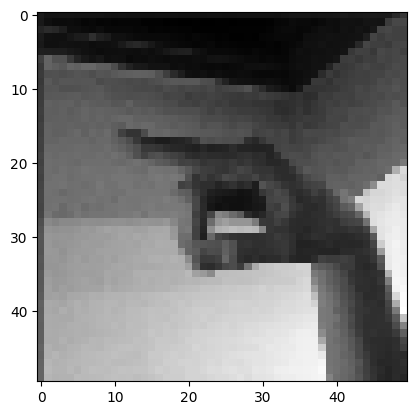

In [190]:
plt.imshow(x_train[6][:,:,0], cmap = 'gray')
plt.show()

In [191]:
# With data augmentation (adding noise + transformation) to prevent overfitting & make more realistic

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [196]:
# create convolutional neural network (CNN) model, https://www.tensorflow.org/tutorials/images/classification
model = Sequential()

# reduce learning rate when starts to stop improving
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# compile model to recognise different data classes & normalise
# add 2D convolution layers, dense layers, batch layers, maxpool, flatten (2D --> 1D)
# condense to 24
# use batching to allow model to handle data more efficiently
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (50,50,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2)) # new
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 27 , activation = 'softmax'))

In [207]:
# Compile the model
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
# changed loss to sparse version, to avoid having to use one-hot values
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 50, 50, 75)        750       
                                                                 
 batch_normalization_12 (Ba  (None, 50, 50, 75)        300       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 25, 25, 75)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 50)        33800     
                                                                 
 dropout_12 (Dropout)        (None, 25, 25, 50)        0         
                                                                 
 batch_normalization_13 (Ba  (None, 25, 25, 50)       

In [208]:
# Train the model! (takes ages)
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test), callbacks = [learning_rate_reduction])

model.save('goated.keras')

# models:
# smnist.h5, smnist2.h5, smnist3.h5

104/254 [===========>..................] - ETA: 1:51 - loss: 2.5254 - accuracy: 0.2793

KeyboardInterrupt: ignored

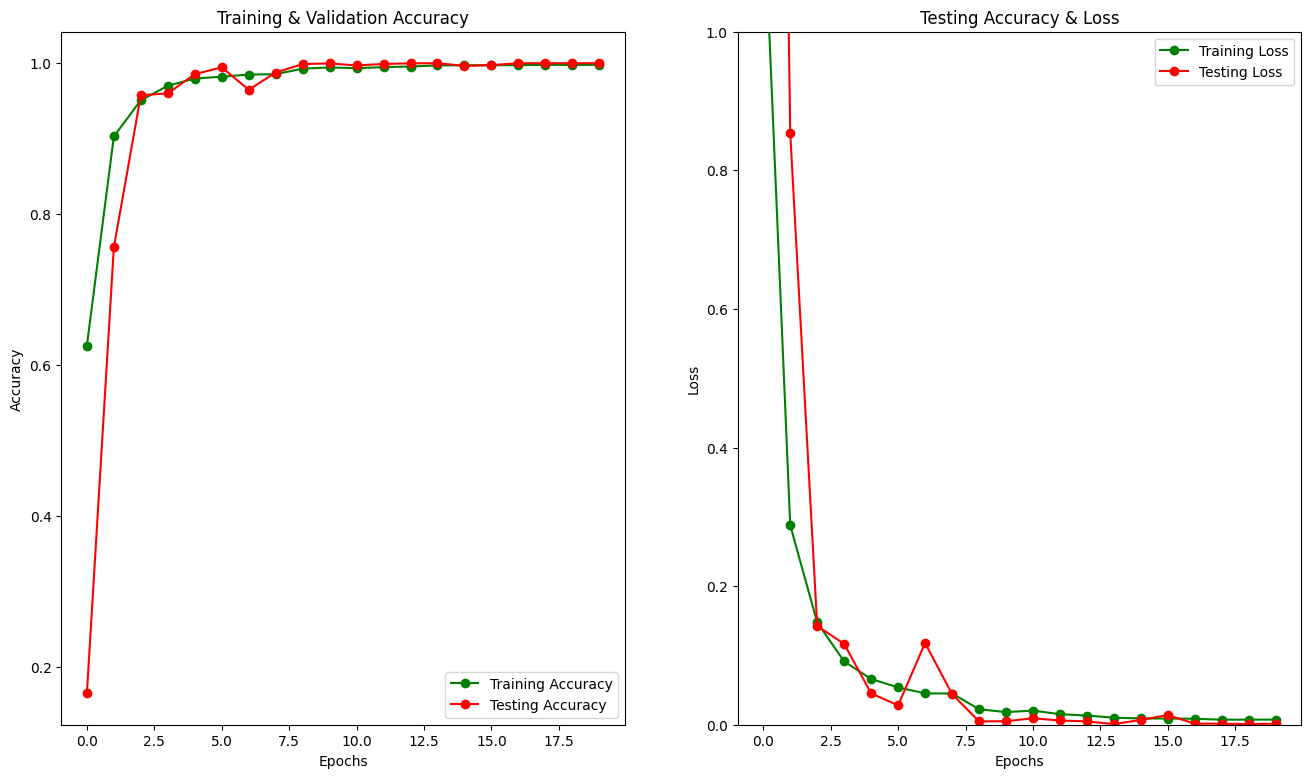

In [14]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.ylim(0,1)

plt.show()

## Processing image

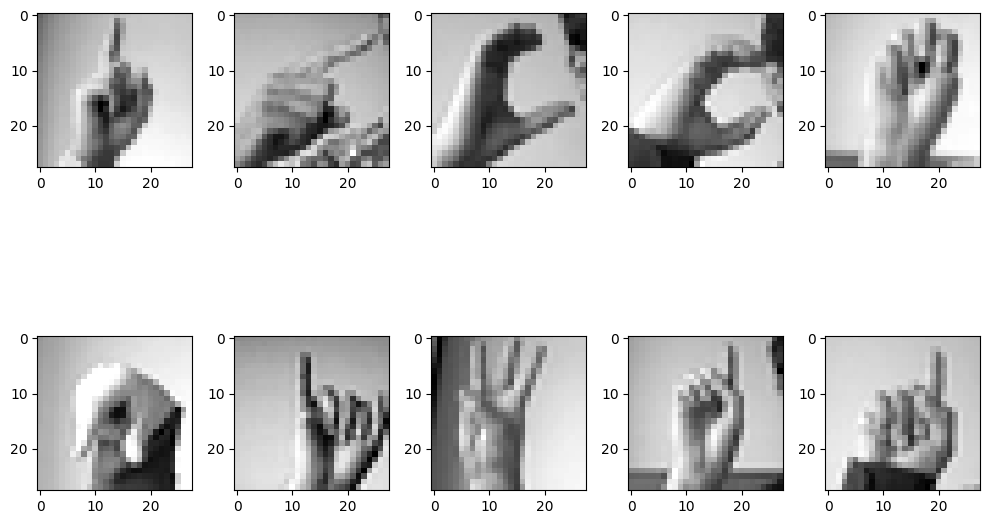

In [81]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

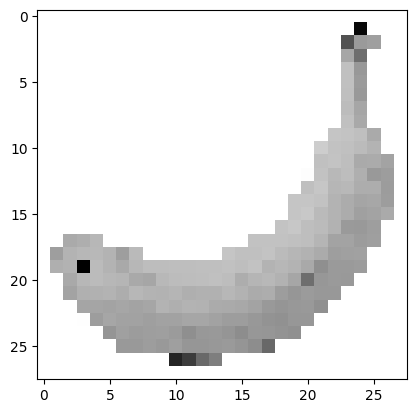

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [118]:
from pandas.core.frame import DataFrame
image_path = '/jpg-of-a-banana.jpg'

image_size = [28,28]

image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1) # channel 0 = default, channel 1 = greyscale, channel 3 = rgb
# image = tf.image.rot90(image,k = -1 )
image = tf.image.resize(image, image_size)
#image = image / 255 # normalise

plt.imshow(image, cmap = 'gray')
plt.show()

np_im = image.numpy()
np_im.resize(1,784)
df = DataFrame()

df = pd.concat([df,pd.DataFrame(np_im)], ignore_index=True)
df.head()

In [91]:
np_image = image.numpy()
model = load_model('smnist3.h5')

data = np_image / 255
data = data.reshape(-1,28,28,1)

prediction = model.predict(data)
predarray = np.array(prediction[0])


1/1 [==============================] - 0s 121ms/step


In [92]:
letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

letter_prediction_dict = {letterpred[i]: predarray[i] for i in range(len(letterpred))}
predarrayordered = sorted(predarray, reverse=True)
high1 = predarrayordered[0]
high2 = predarrayordered[1]
high3 = predarrayordered[2]
for key,value in letter_prediction_dict.items():
    if value==high1:
        print("Predicted Character 1: ", key)
        print('Confidence 1: ', 100*value)
    elif value==high2:
        print("Predicted Character 2: ", key)
        print('Confidence 2: ', 100*value)
    elif value==high3:
        print("Predicted Character 3: ", key)
        print('Confidence 3: ', 100*value)

Predicted Character 1:  G
Confidence 1:  73.09092879295349
Predicted Character 2:  L
Confidence 2:  23.71916025876999
Predicted Character 3:  X
Confidence 3:  2.591024711728096
